<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Natural Language Processing</h1>
        <h1>Topic Modeling</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import string
from collections import Counter
from pprint import pprint
import gzip

import matplotlib
import matplotlib.pyplot as plt 

import nltk
from nltk.text import TextCollection

import numpy as np
from numpy.linalg import svd
from numpy import diag

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import LatentDirichletAllocation

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: dcc62f994628bd6ae202ab542b8409b1167569d6

nltk      : 3.5
json      : 2.0.9
numpy     : 1.19.2
matplotlib: 3.3.2
sklearn   : 0.0
watermark : 2.1.0



Set the default style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Preprocessing

Load a standard list of stopwords from a file

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
list(stopwords)[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Since we'll be using tweets, we start by instantiating the TweetTokenizer. This will ensure that we preserve #tags, @usernames, etc

In [6]:
tokenizer = nltk.tokenize.TweetTokenizer()

Process the data from the file. File was obtained from crowdflower (https://www.crowdflower.com/data-for-everyone/) and contains a list of tweets about Apple from 2014 and some information about their sentiment. For our purposes, we only care about the text of each tweet that is located in the last column of the csv file.

We treat each tweet as an individual document, and limit ourselves to only the first 200 tweets.

In [7]:
tweets = []
line_count = 0

for line in open("data/Apple-Twitter-Sentiment-DFE.csv", "rt"):
    fields = line.strip().split(',')
    
    line_count += 1
    
    # Skip the first line of the file which contains the header
    if line_count == 1:
        continue
    
    text = ",".join(fields[11:])
    
    if len(text) == 0:
        continue
    
    words = tokenizer.tokenize(text.lower())
    clean_words = []
    
    for word in words:
        if word in stopwords\
        or word in string.punctuation\
        or "/" in word:
            continue
            
        clean_words.append(word)
    
    if len(words) > 0:
        tweets.append(clean_words)
        
    if len(tweets) == 500:
        break

In [8]:
tweets[:5]

[['cat', 'chews', '@apple', 'cords', '#applesnob'],
 ['nobody', 'expects', 'spanish', 'inquisition', '#aapl'],
 ['#aapl',
  '5',
  'rocket',
  'stocks',
  'buy',
  'december',
  'gains',
  'apple',
  '...'],
 ['top', '3', '@apple', '#tablets', 'damn', 'right'],
 ['apple', 'inc', 'flash', 'crash', 'need', 'know', '#aapl']]

Define the function to calculate the Inverse Document Frequency for each word and the TFIDF matrix.

In [9]:
corpus = TextCollection(tweets)

In [10]:
corpus

<Text: cat chews @apple cords #applesnob nobody expects spanish...>

Get the TFIDF matrix for our corpus of tweets. We should note that while we call it a matrix, this is effectively a list of dictionaries, which we can consider to be a sparse representation of a matrix.

In [11]:
TFIDF = []

for tweet in tweets:
    score = {}
    
    for token in set(tweet):
        score[token] = corpus.tf_idf(token, tweet)
        
    TFIDF.append(score)

In [12]:
TFIDF

[{'chews': 1.2429216196844384,
  '#applesnob': 1.2429216196844384,
  'cords': 1.1042921835724493,
  '@apple': 0.090511343128403,
  'cat': 1.1042921835724493},
 {'nobody': 1.2429216196844384,
  'spanish': 1.2429216196844384,
  'expects': 1.2429216196844384,
  'inquisition': 1.2429216196844384,
  '#aapl': 0.21458890838390637},
 {'apple': 0.19177463652111687,
  'rocket': 0.6905120109357991,
  '5': 0.4742997721518754,
  'stocks': 0.6134956575402495,
  'december': 0.5364793041447001,
  'buy': 0.3896175441466646,
  'gains': 0.6905120109357991,
  '#aapl': 0.11921606021328131,
  '...': 0.26754951207243016},
 {'3': 0.8047189562170503,
  'right': 0.7371414381990228,
  '@apple': 0.07542611927366916,
  'damn': 0.8047189562170503,
  '#tablets': 1.0357680164036984,
  'top': 0.852665968292347},
 {'know': 0.6578814551411559,
  '#aapl': 0.15327779170279024,
  'inc': 0.48305639348085366,
  'flash': 0.6578814551411559,
  'apple': 0.24656738981286455,
  'crash': 0.6098139927666969,
  'need': 0.51079296697

For convenience, extract the word_dict and word_list from the TFIDF matrix.

In [13]:
word_list = list(corpus.vocab().keys())
word_dict = dict(zip(word_list, np.arange(len(word_list))))

In [14]:
vocabulary_size = len(word_dict)
print("We have", vocabulary_size, "words in our vocabulary")

We have 1939 words in our vocabulary


In [15]:
word_list[:10]

['cat',
 'chews',
 '@apple',
 'cords',
 '#applesnob',
 'nobody',
 'expects',
 'spanish',
 'inquisition',
 '#aapl']

Now use the TFIDF matrix and our vocabulary to generate the Term Document matrix. This is just a matter of rearranging the values in our (sparse) TFIDF matrix into the full TD matrix.

In [16]:
def term_document_matrix(TFIDF, word_list, word_dict):
    vocabulary_size = len(word_dict)
    number_documents = len(TFIDF)
    
    TDM = np.zeros((vocabulary_size, number_documents))
    
    for doc in range(number_documents):
        document = TFIDF[doc]
        
        for word in document.keys():
            pos = word_dict[word]
            
            TDM[pos, doc] = document[word]
            
    return TDM

In [17]:
TDM = term_document_matrix(TFIDF, word_list, word_dict)
print("Our dataset has:\n%u unique words\n%u documents"%(TDM.shape))

Our dataset has:
1939 unique words
500 documents


In [18]:
TDM.shape

(1939, 500)

## Explicit Semantic Analysis

In ESA we use the TD matrix of our corpus as a knowledge base that we can use to look up related documents. To demonstrate how this works, let's create a new document:

In [19]:
new_tweet = ['#macbook', 'mini', 'rocket']

This is not an actual sentence since, for clarity, we are not including stopwords.

In the TD formulation, the values in the word (row) vector representa how much each document is "activated" by that specific word. Naturally, documents in which the word does not appear have weight zero. We can use these word vectors to find a vector representation of our new document where each value is our related it is to every other document in our knowledge base. You can think of this as the set of results one might obtain after a query in a search engine!

The **find_related** simply calcuates the vector corresponding to the new "document" and returns a list of the corresponding weights sorted in decreasing order:

In [20]:
def find_related_docs(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
        
    # Now the entries of new_vector tell us which documents are activated by this one.
    # Let's extract the list of documents sorted by activation
    doc_list = sorted(zip(range(TDM.shape[1]), new_vector), 
                      key=lambda x:x[1], reverse=True)
    
    return doc_list

In [21]:
related = find_related_docs(new_tweet, TDM)

Let's take a look a the top 5 results:

In [22]:
for tweet, score in related[:5]:
    print(score, tweet, " ".join(tweets[tweet]))

0.6905120109357991 2 #aapl 5 rocket stocks buy december gains apple ...
0.59313210196533 167 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
0.59313210196533 191 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
0.59313210196533 388 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
0.5140478217032859 168 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox


With such small documents, the results are easy to interpret. The first two result are due to mentions of **macbook** and **mini**, the third due to the presence of the word **rocket** but the remaining two results don't include any words in common with our original tweet, just words that appear in similar contexts.

In [23]:
def find_similar_words(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
    
    sim = [cosine_similarity(new_vector.reshape(1, -1), 
                             TDM[i, :].reshape(1, -1)).flatten()[0] for i in range(TDM.shape[0])]

    sim_words = sorted(zip(range(TDM.shape[0]), sim), 
                       key=lambda x:x[1], reverse=True)
    return sim_words

In [24]:
similar = find_similar_words(new_tweet, TDM)

In [25]:
new_tweet

['#macbook', 'mini', 'rocket']

In [26]:
for word, score in similar[:20]:
    print("%s: %g" % (word_list[word], score))

#macbook: 0.8216
@youtube: 0.805338
#startup: 0.805338
#hipster: 0.805338
mini: 0.787466
#ipadmini: 0.765211
#macbookpro: 0.680949
unboxing: 0.605678
#unboxing: 0.605678
startup: 0.530861
#unbox: 0.50116
#ipad: 0.467151
via: 0.452331
ipad: 0.420346
first: 0.401098
rocket: 0.388672
gains: 0.388672
pro: 0.3433
13in: 0.290492
jh: 0.2691


This approach also returns words that are not included in the document but that are used in a similar context, such as #hipster. One might use this extra words (above some finetuned threshold of similarity) to expand our query and retrieve furhter related documents.

# Clustering Documents

For simplicity we use the AgglomerativeClustering algorithm from sklearn and the visualization code from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [27]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Define an train the model. For the sake of visualization, we limit ourselves to just 50 documents instead of the whole set. Also note that we must use the transpose of the TDM matrix to ensure that we are clustering documents and not tokens

In [28]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(TDM.T[:50])

We can confirm that we have the right number of features (tokens)

In [29]:
model.n_features_in_

1939

Finally, we plot the dendrogram

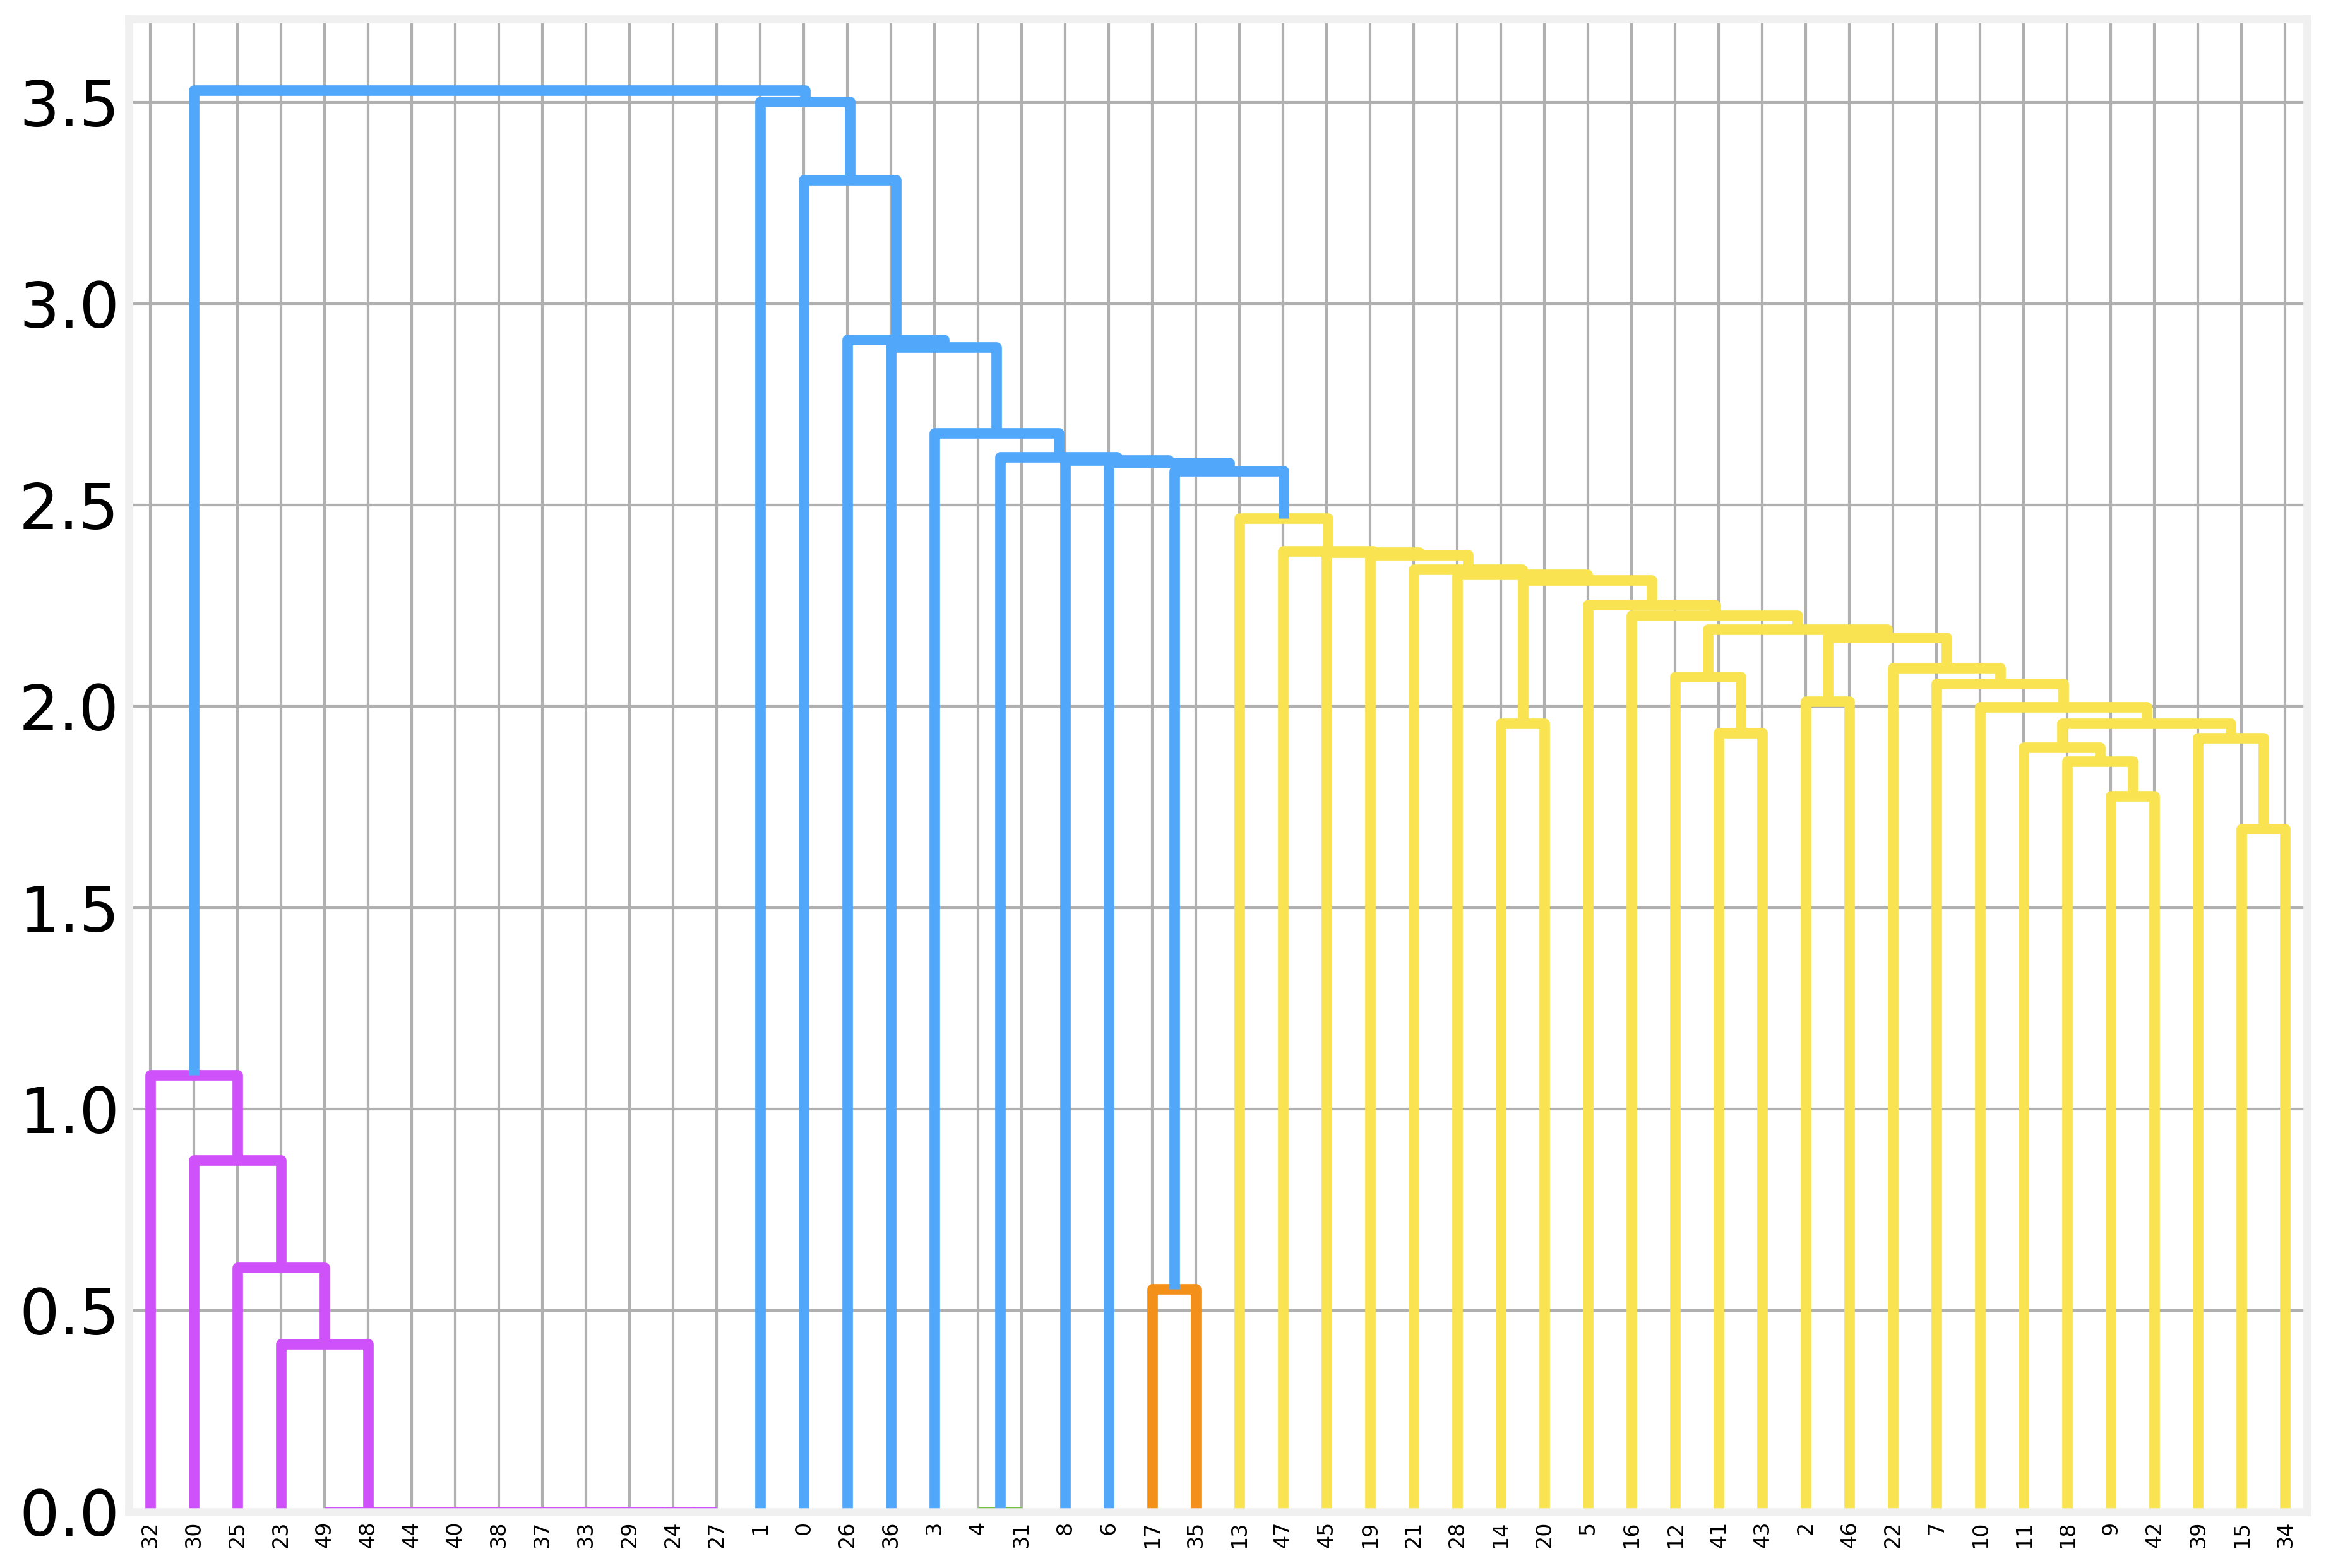

In [30]:
plot_dendrogram(model)

## Latent Semantic Analysis

LSA analysis, sometimes refered to as Latent Semantic Indexing, relies on the well known Singular Value Decomposition. Singular Values (and Singular Vectors) can be thought of as being a generalization of the more common eigenvalues (and eigenvectors) for the case of non-square matrices. 

The first step in any LSA analysis is to apply SVD to the Term-Document matrix:

In [31]:
u, sigma, vt = svd(TDM)

The resulting matrices have the expected shapes, except the singular value matrix, **sigma** that is simply a vector. This is an optimization of the numpy function meant to save memory.

In [32]:
m, n = TDM.shape
print(u.shape, sigma.shape, vt.shape)

(1939, 1939) (500,) (500, 500)


In [33]:
print(m, n)

1939 500


We can now reduce the internal dimension of these matrices to, say, 10. 

In [34]:
k = 20

# Convert the vector of singular values into a diagonal matrix
sigma_k = sigma[:k]
Sk = diag(sigma_k)

# Drop the extraneous dimensions in the other two matrices.
uk = u[:,:k]
vtk = vt[:k, :]

In this way, we preserve the most significant (higher sigma values) latent dimensions of the dataset while discarding the rest. The idea is simple, SVD projects the original dataset into an internal space which is a linear combination of the original one. Each dimension in this space can be thought of as an underlying topic in the data. By preserving only the most dominant topics in effect we are simplifying the data and, potentially, removing noise. 

In [35]:
print(uk.shape, Sk.shape, vtk.shape)

(1939, 20) (20, 20) (20, 500)


There are no easy ways to determine the number of topics to choose, but a good rule of thumb is to identify kinks in the values of sigma

Text(0, 0.5, '$\\sigma_i$')

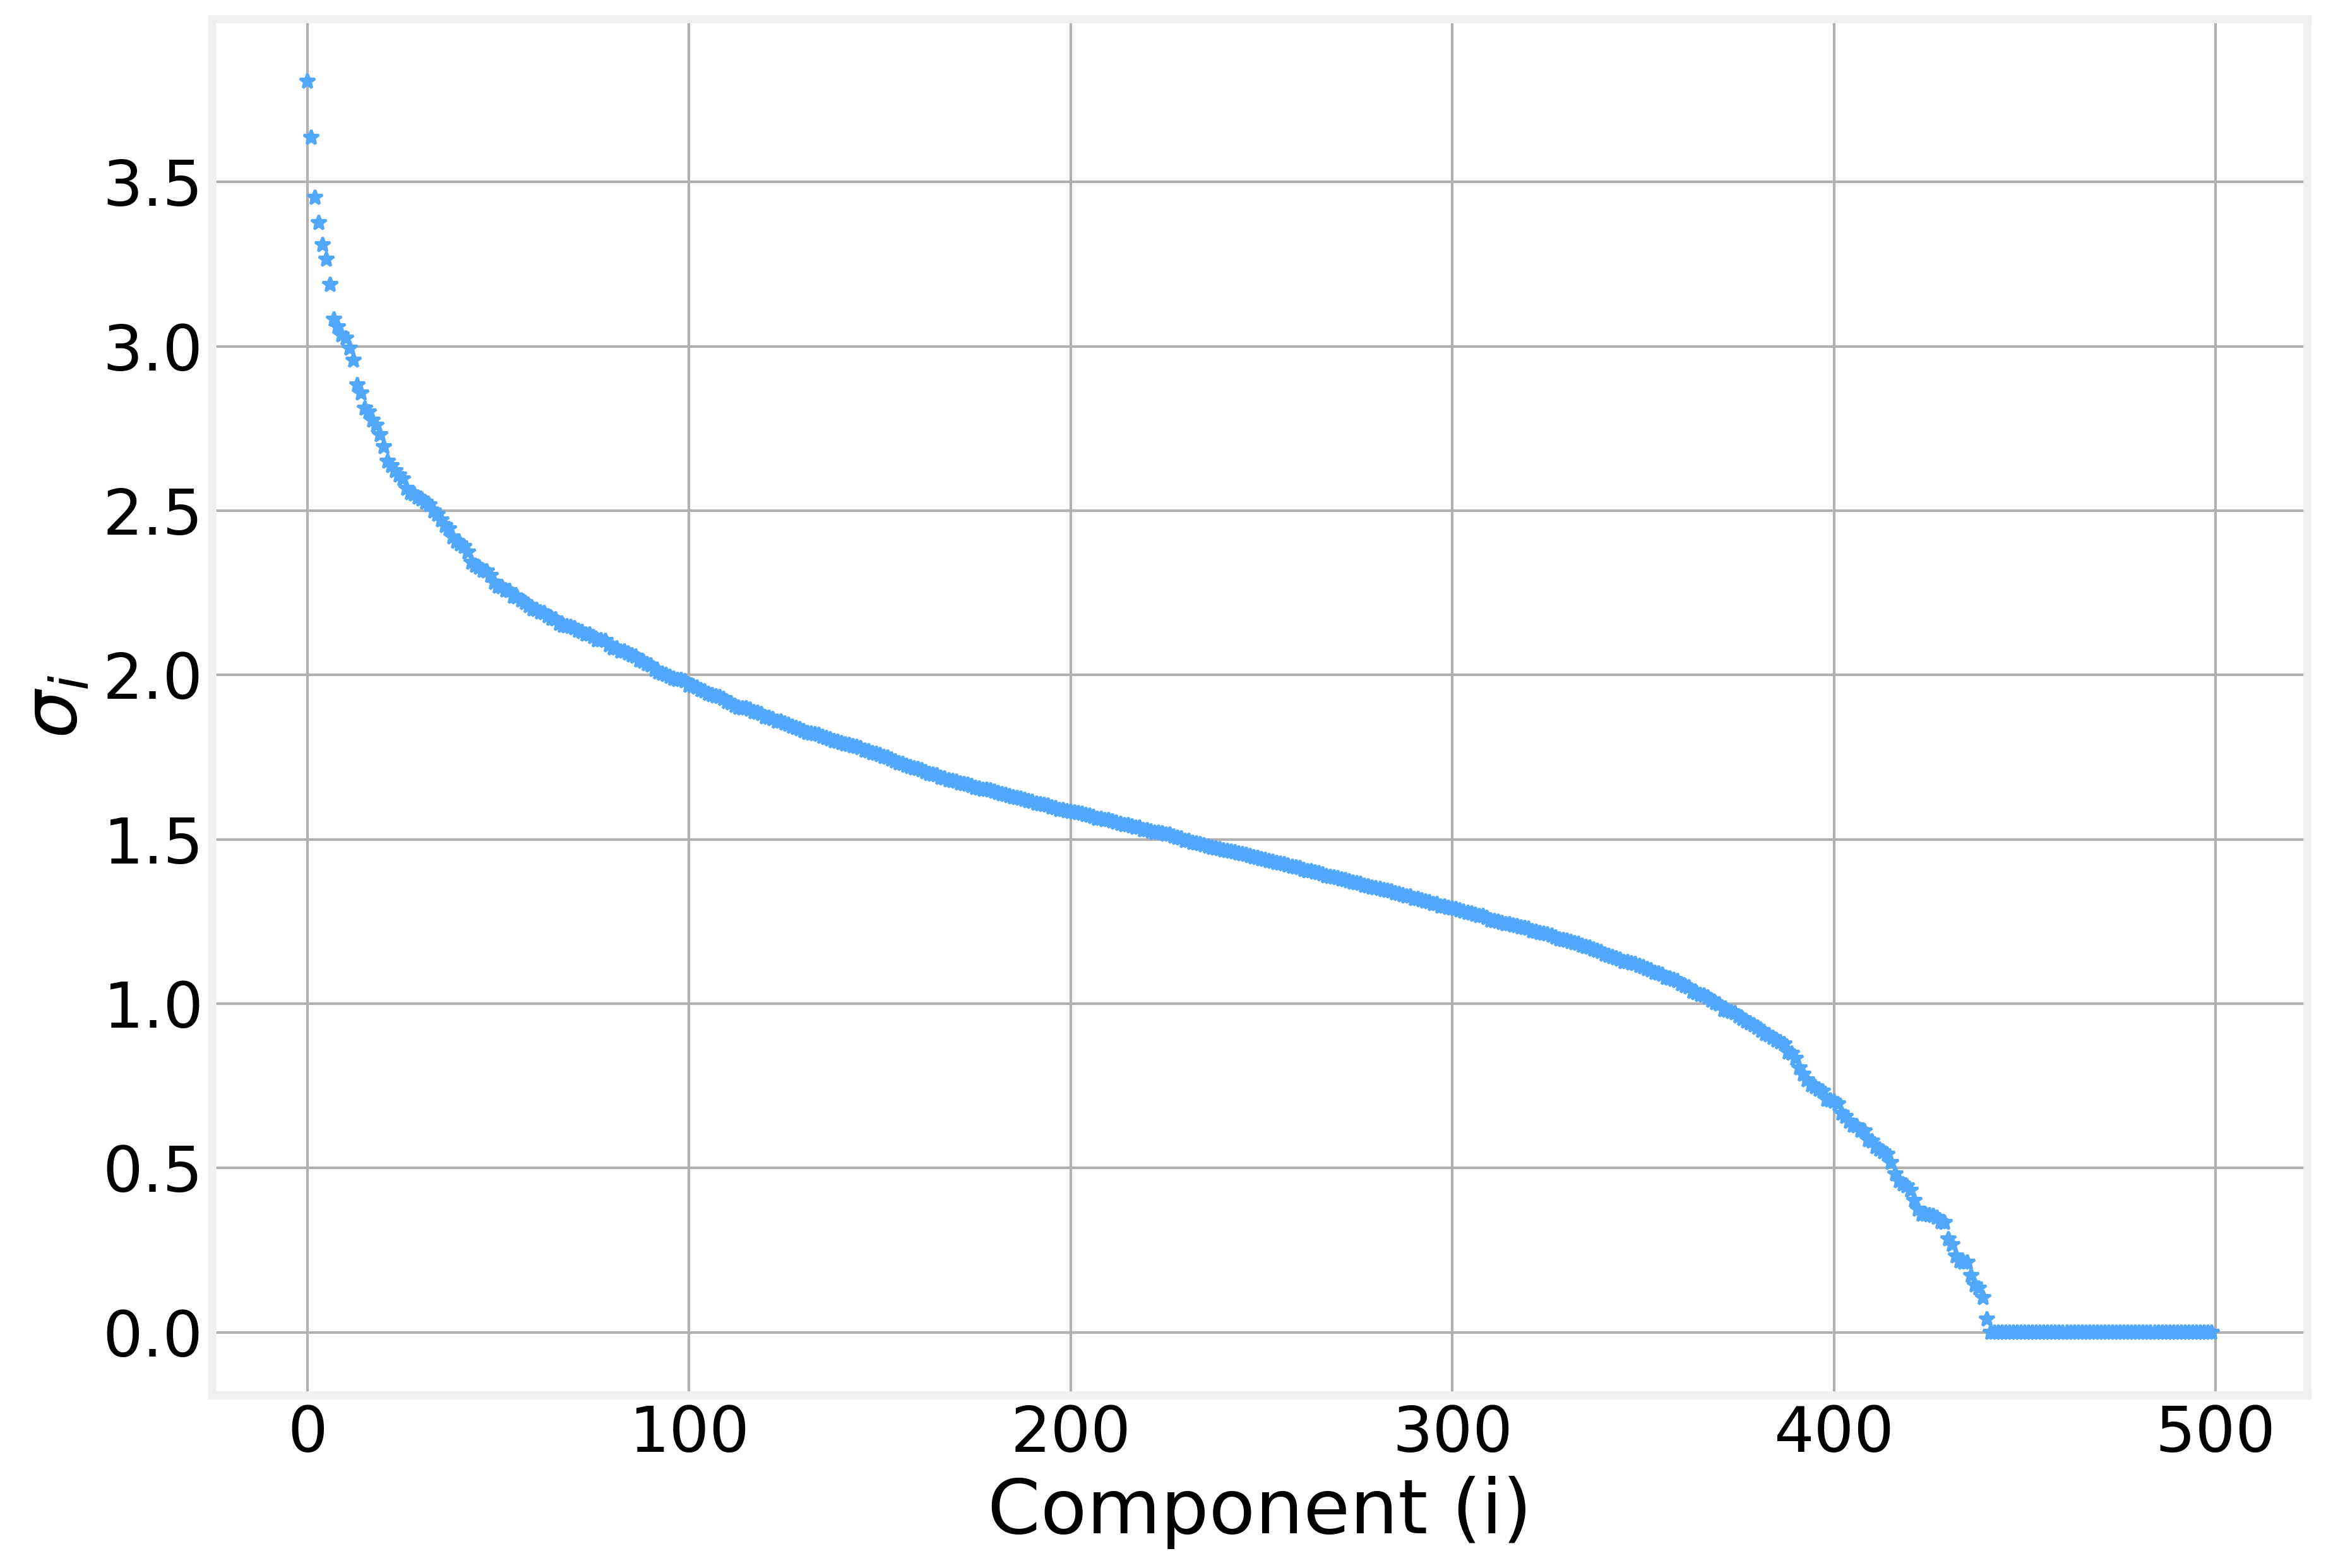

In [36]:
plt.plot(range(500), sigma, '*')
plt.xlabel('Component (i)')
plt.ylabel(r'$\sigma_i$')

We can also explore the way in which the topics are defined by considering the words for which they have stronger weights:

In [37]:
# Sort the list of words by the weight they have in a specific topic
def top_words(vector, word_list):
    doc_list = sorted(zip(word_list, vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

For example, for topic 1, we have strong mentions of the justice department and a recent federal law decision about unlocking iphones:

In [38]:
topic_words = top_words(uk[:,1], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

federal 0.2606022427576014
law 0.2606022427576013
department 0.26060224275760124
cites 0.2606022427576012
18th 0.2606022427576011
century 0.2606022427576009
unlock 0.2594558729061549
justice 0.25840277676163026
iphones 0.25396942955389934
@thehill 0.24845399158974746


On the other hand, if we were trying to map a specific sentence or document into the most relevant topic we would simply have to project it into the singular space. First we define the vector in the "regular" word space:

In [39]:
document = ['ipad', 'mini', 'price']

doc_vector = np.zeros(vocabulary_size)
for word in document:
    doc_vector[word_dict[word]] += 1

and now we project it into the singular space:

In [40]:
doc_singular = 1/sigma_k*np.dot(uk.T, doc_vector)
pprint(doc_singular)

array([-0.02795687, -0.01210723, -0.00019639,  0.00096848,  0.01986759,
        0.00152401, -0.02277111,  0.06085907,  0.0134054 ,  0.03140215,
        0.00564585,  0.0869532 ,  0.03682714, -0.00405679,  0.01681271,
        0.01352978, -0.0132486 ,  0.02266492, -0.01178019, -0.00777679])


From where we see that the most relevant topic is topic number 11:

In [41]:
topic = np.argmax(doc_singular)

print(topic)

topic_words = top_words(uk[:,topic], word_list)
for word, weight in topic_words[:20]:
    print(word, weight)

11
thank 0.29774557331500123
#macbookpro 0.25909565050446215
via 0.24120410802252296
@youtube 0.2393559575276826
#startup 0.2393559575276826
#hipster 0.2393559575276826
#macbook 0.23480658188636672
yall 0.1720307865112455
#unboxing 0.1561683573715782
unboxing 0.15616835737157808
ipad 0.14586152423301893
pro 0.1403175419202523
mini 0.13966101518736398
#ipadmini 0.13721958345536686
update 0.13650380565448705
#ipad 0.13097471890592483
headphones 0.13031555454628735
startup 0.12767076037561614
hoes 0.1270331432809359
first 0.1242343861347427


Which indeed seems relevant.

# Latent Dirichlett Allocation

In [42]:
lda = LatentDirichletAllocation(n_components = 15, random_state = 42)
lda.fit(TDM.T)

LatentDirichletAllocation(n_components=15, random_state=42)

In [43]:
lda.components_.shape

(15, 1939)

In [44]:
for i, topic in enumerate(lda.components_):
        print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in np.array(word_list)[topic.argsort()[-10:]]])))

Topic 1: digital, claims, long, #tuesday, lol, #passingthetime, #interestingfact, #whoknew, drop, dying
Topic 2: customer, companies, hoes, band, brass, @donacamp, #nyc, #winterseve, broadway, #aapl
Topic 3: pro, unboxing, #unboxing, #ipad, via, #macbookpro, #hipster, @youtube, #startup, #macbook
Topic 4: rt, headphones, new, @ace_kit_uk, apple, macbook, thank, 949.86, £, â
Topic 5: contra, juicio, en, clave, aapl, update, intraday, fibonacci, technicals, levels
Topic 6: iphones, @thehill, unlock, law, federal, department, cites, 18th, century, get
Topic 7: dual, pie, perfome, unlike, @apple, dear, fix, fuck, apps, #ipodtouch5thgen
Topic 8: demand, @_iamgambino, lighting, #gorgeous, #grandcentralstation, via, back, boost, strong, thestreet
Topic 9: u, #stevejobs, phone, @laurrynk, everything, h8, battery, replace, dear, sucks
Topic 10: peanut-butter-sandwich, download, pre-opening, 2, photo, phones, ur, @kcdenton, salut, disgrace
Topic 11: screenshot, @timcook, analyst, @jimcramer, tak

## Non-Negative Matrix Factorization

The idea behind applying NMF to a Term-Document Matrix is similar to the goals behind using SVD to perform Latent Semantic Analysis. NMF is a general matrix factorization algorithm and, as such, the factor matrices it finds can also be thought of as internal or latent dimensions. 

Similarly to the case of SVD, we can perform a partial reconstruction of the original matrix by reducing the internal dimensions. Naturally, as the number of latent dimensions increases, the reconstruction error decreases since we are removing less and less information

Let's see how the error changes with the number of components.

In [45]:
error = []

for comps in range(2, 55+1):
    nmf = NMF(n_components=comps, init='nndsvd', max_iter=2000).fit(TDM.T)
    print(comps, nmf.reconstruction_err_)
    error.append(nmf.reconstruction_err_)

2 34.92909306432304
3 34.75885142305044
4 34.59474584516742
5 34.436737900669854
6 34.283354608632585
7 34.14211229794063
8 34.00701523608933
9 33.86834656271416
10 33.73509055151144
11 33.5987653008573
12 33.46638007157678
13 33.33565422036654
14 33.211814323541304
15 33.08996033844725
16 32.970247396590864
17 32.85160134805465
18 32.7364144685185
19 32.62232570057751
20 32.51095780916808
21 32.40271179935124
22 32.29287252680941
23 32.18515670501462
24 32.07946638065171
25 31.98388824386346
26 31.878872946443135
27 31.7744171526719
28 31.678199564399286
29 31.576251453392846
30 31.487823030117312
31 31.38094907519989
32 31.282054432019027
33 31.180472275091837
34 31.09110945457155
35 30.983281066179106
36 30.88927031737777
37 30.821912750960752
38 30.707708000269506
39 30.638623294641057
40 30.503433891629747
41 30.44710039356214
42 30.325078015030257
43 30.247367650966353
44 30.15567324609506
45 30.05809994221714
46 29.989157723275632
47 29.894579074225366
48 29.80681208100353
49 29

Any nan values found above are due to numerical instabilities. In practice you should use a well tested numerical library such as sklearn.

Text(0.5, 1.0, 'Non-Negative Matrix Factorization')

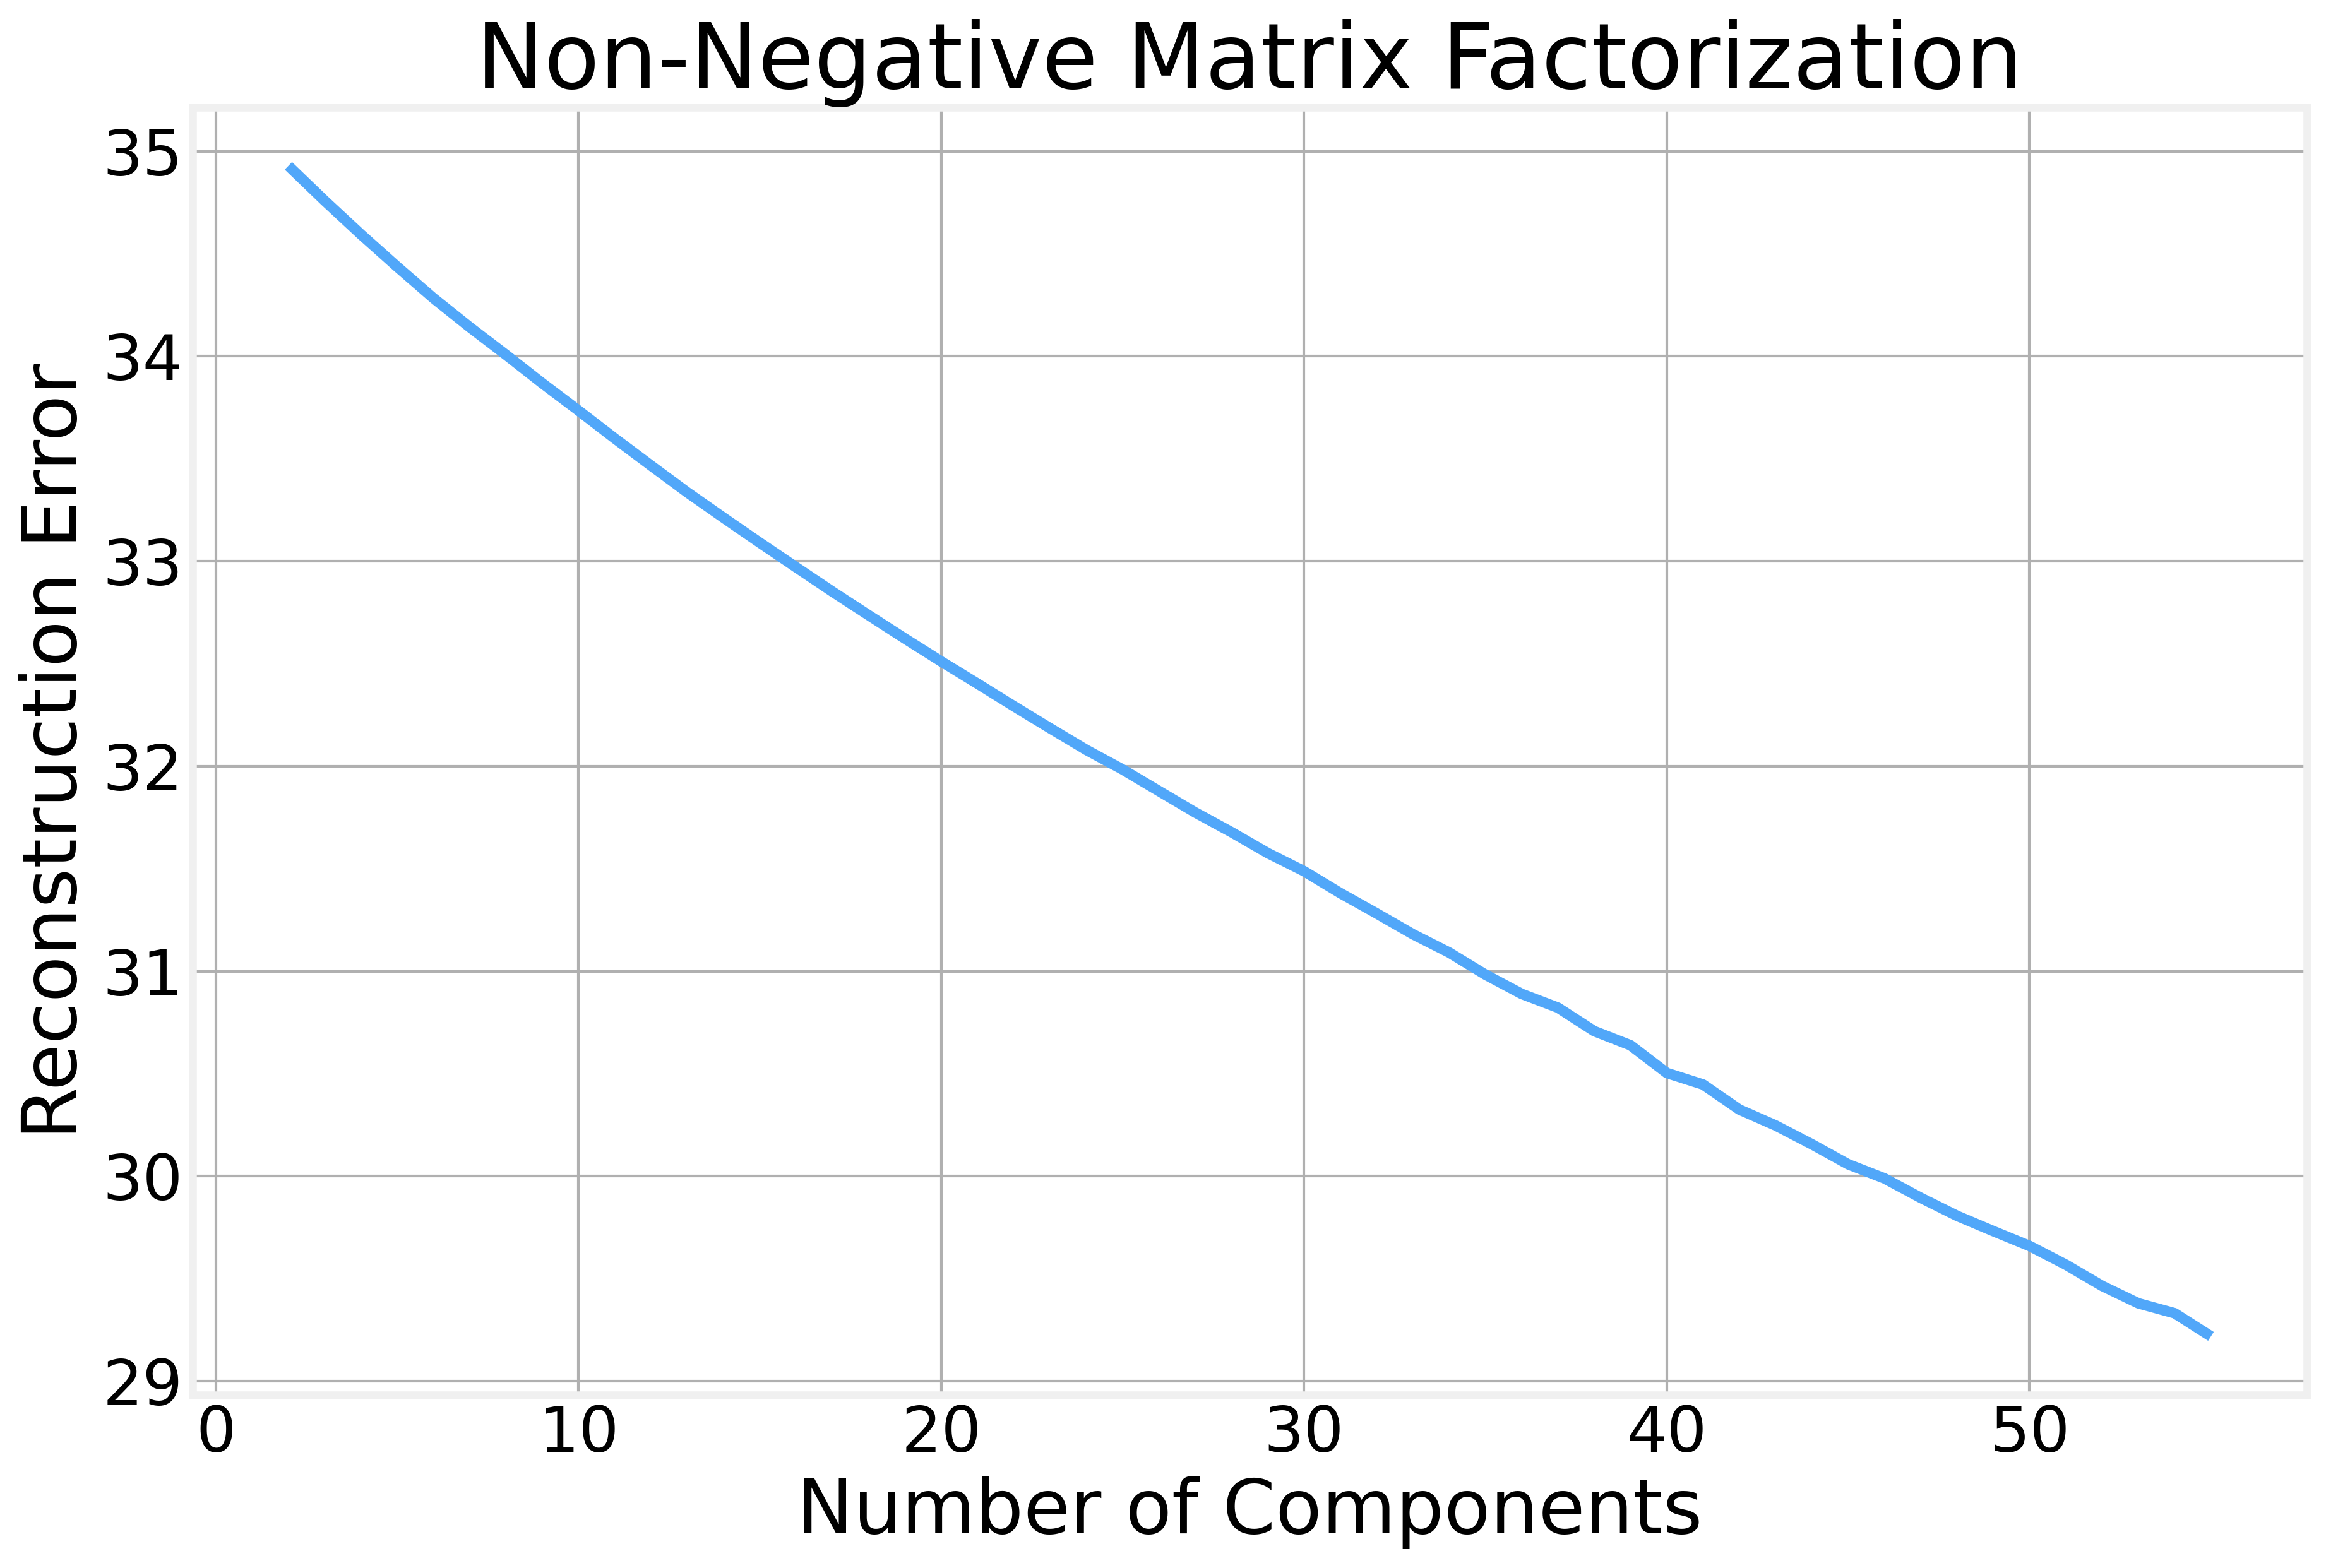

In [46]:
plt.plot(range(2, 55+1), error)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Non-Negative Matrix Factorization')

For the remainder of this section, lets fix the number of so that we can use these results to illustrate the power of NMF.

In [47]:
nmf = NMF(n_components=10, init='nndsvd', max_iter=2000)
W = nmf.fit_transform(TDM.T)
H = nmf.components_
err = nmf.reconstruction_err_

In [48]:
W.shape

(500, 10)

When we apply NMF to a Term-Document matrix, as defined above, the resulting factors prove useful for topic detection. In particular, the W matrix provides us with the definition of each topic as a weighted distribution over all the words in the corpus:

Let's look at a the top words for each topic

In [49]:
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in np.array(word_list)[topic.argsort()[-10:]]])))

Topic 1: @jpdesloges, last, #aapl, apple, aapl, update, fibonacci, technicals, levels, intraday
Topic 2: @thehill, iphones, justice, unlock, law, century, cites, department, federal, 18th
Topic 3: @apple, right, imessage, acid, yo, shitty, 3g, draining, @remuuusss, fix
Topic 4: comparison, #design, drop, ios, rendition, audio, requirement, @apple, apps, #ipodtouch5thgen
Topic 5: @youtube, #macbookpro, #macbook, rt, apple, @ace_kit_uk, macbook, £, â, 949.86
Topic 6: @apple, replace, sucks, keeps, freezing, hate, faggots, dear, phone, fucking
Topic 7: peaked, 6, #iphone, aapl, inc, cnbctv, apple, ..., #apple, #aapl
Topic 8: emails, trial, rt, @elnuevoherald, contra, juicio, en, clave, steve, jobs
Topic 9: music, @apple, breaking, @brwnskin_beauti, cause, lol, shit, dying, hey, fuck
Topic 10: people, @_iamgambino, rt, @apple, thank, @jodispicer, #passingthetime, #interestingfact, #whoknew, twitter


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>